<a href="https://colab.research.google.com/drive/1N2iEW-PMQiFTAL1GSYDADZZITtKSmwCU#scrollTo=xFazOG6BItfj" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRI segmentation with 3D U-net**

#### 1. Introduction

In this section we will segment gray matter and subcortical nuclei from preprocessed MRI image.

*Proceeding with this Notebook you confirm your personal acess [to the data](https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release). 
 And your agreement on data [terms and conditions](https://www.humanconnectome.org/study/hcp-young-adult/data-use-terms).*


In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Create an experiment with your api key
experiment = Experiment(
    api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
    project_name="mri-segmentation-2021",
    workspace="kondratevakate",
)

     |████████████████████████████████| 394 kB 5.2 MB/s 
     |████████████████████████████████| 54 kB 1.5 MB/s 
     |████████████████████████████████| 158 kB 58.4 MB/s 
     |████████████████████████████████| 495 kB 69.3 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 140 kB 75.0 MB/s 
     |████████████████████████████████| 127 kB 68.5 MB/s 
     |████████████████████████████████| 157 kB 74.2 MB/s 
     |████████████████████████████████| 157 kB 75.8 MB/s 
     |████████████████████████████████| 157 kB 77.7 MB/s 
     |████████████████████████████████| 157 kB 76.1 MB/s 
     |████████████████████████████████| 157 kB 78.9 MB/s 
     |████████████████████████████████| 157 kB 74.2 MB/s 
     |████████████████████████████████| 157 kB 73.7 MB/s 
     |████████████████████████████████| 156 kB 74.4 MB/s 


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/kondratevakate/mri-segmentation-2021/8522cfc7abf742cc9f5563b587535159



The code is adopted from `Torchio` library tutorials: 

https://colab.research.google.com/drive/112NTL8uJXzcMw4PQbUvMQN-WHlVwQS3i

#### 2. Mounting Google drive

Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Add a shortcut to your drive:

https://drive.google.com/drive/folders/1GCIXnK6ly5l_LADanpLmvtZ6YbqPUamQ?usp=sharing

In [4]:
data_dir = '/content/drive/My Drive/Skoltech Neuroimaging/NeuroML2020/data/seminars/anat/fs_segmentation'

In [5]:
len(os.listdir(data_dir))

629

In [6]:
os.listdir(data_dir)[-30:-20]

['HCP_T1_fs6_121820_aparc+aseg.nii.gz',
 'HCP_T1_fs6_121719_aparc+aseg.nii.gz',
 'HCP_T1_fs6_122317_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123117_aparc+aseg.nii.gz',
 'HCP_T1_fs6_122418_aparc+aseg.nii.gz',
 'HCP_T1_fs6_121921_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123723_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123925_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123824_aparc+aseg.nii.gz',
 'HCP_T1_fs6_124220_aparc+aseg.nii.gz']

#### 3. Defining the dataset

Defining the working dataset, there:

 1. `norm` - normalised `T1` image processed with Freesurfer 6.0,

 2. `aparc+aseg` segmentation mask for gray matter and subcortical nuclei from Freesufer 6.0 `recon all` pipeline.

 And U-net model will treat `norm` image as input and `aparc+aseg` as target model.

In [7]:
import pandas as pd
labels_dir  = '/content/drive/My Drive/Skoltech Neuroimaging/NeuroML2020/data/seminars/anat/'
labels = pd.read_csv(labels_dir + 'unrestricted_hcp_freesurfer.csv')

Defining new `pd.Dataframe()` with `Subject`, `norm` and `target` files:

In [8]:
data_list = pd.DataFrame(columns = ['Subject','norm','aseg'])

In [9]:
data_list['Subject'] = labels['Subject']

Iterating through files and `Subjects` in ID list:

In [10]:
from tqdm import tqdm

for i in tqdm(os.listdir(data_dir)):
  for j in range(0, len(data_list['Subject'])):

    if str(data_list['Subject'].iloc[j]) in i:
      if 'norm' in i: # copying path to the column norm
        data_list['norm'].iloc[j] = data_dir +'/'+ i
      elif 'aseg' in i: # copying path to second column
        data_list['aseg'].iloc[j] = data_dir +'/'+ i
      
data_list.dropna(inplace= True)

  0%|          | 0/629 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 629/629 [00:06<00:00, 96.57it/s]


In [11]:
data_list.head()

,Subject,norm,aseg
4,101006,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
5,101107,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
6,101309,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
7,101410,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
8,101915,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...


Let's have a closer look on the data:

In [12]:
data_list['norm'].iloc[0]

'/content/drive/My Drive/Skoltech Neuroimaging/NeuroML2020/data/seminars/anat/fs_segmentation/HCP_T1_fs6_101006_norm.nii.gz'

     |████████████████████████████████| 9.6 MB 5.0 MB/s 


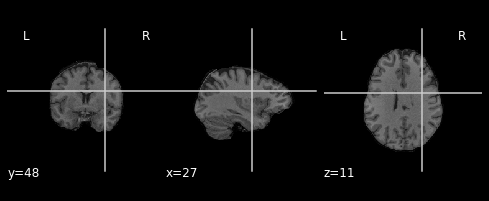

In [13]:
!pip install --quiet --upgrade nilearn
import nilearn
from nilearn import plotting

# visualising normalised image
img = nilearn.image.load_img(data_list['norm'].iloc[0])
plotting.plot_anat(img)

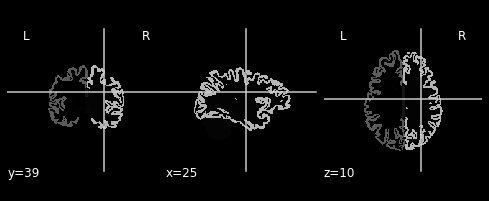

In [15]:
# visualising segmentation
img = nilearn.image.load_img(data_list['aseg'].iloc[0])
plotting.plot_anat(img)

In [16]:
np.unique(img.get_data())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


array([   0,    2,    3,    4,    5,    7,    8,   10,   11,   12,   13,
         14,   15,   16,   17,   18,   24,   26,   28,   30,   31,   41,
         42,   43,   44,   46,   47,   49,   50,   51,   52,   53,   54,
         58,   60,   62,   63,   77,   85,  251,  252,  253,  254,  255,
       1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022,
       1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033,
       1034, 1035, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035], dtype=int32)

Any suggestions on these numbers?

| Structure | Seg ID |
| ----------------- | ----|
| Left-Lateral-Ventricle | 4 |
| Left-Inf-Lat-Vent | 5 | 
| 3rd-Ventricle | 14 |
| 4th-Ventricle | 15 |
| Brain Stem | 16 |
| Left Hippocampus | 17 |
| Left Amygdala | 18 |
| Right-Lateral-Ventricle | 43 |
| Right-Inf-Lat-Vent | 44| 
| Right Hippocampus | 53 |
| Right Amygdala | 54 |
| 5th-Ventricle | 72 |

1. Ventrices - cognitive impairment, aging, Alzheimer's. [1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6601311/)

2. Brain Stem - cognitive impairment,  metabolic pathway disorders (Parkinson): [2](https://pubmed.ncbi.nlm.nih.gov/15240431/), [3](
https://pubs.rsna.org/doi/full/10.1148/rg.2019180126)


2. Hippocampus and Amygdala - autism spectrum disorders, epilepsy [4](https://d-nb.info/1137998318/34)





![Ventricels](https://www.thoughtco.com/thmb/jT1auUqpiaZNZjg-9AHX3eq9yrA=/768x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/brain_ventricles-56d0ccd03df78cfb37b876dc.jpg)

#### 4. Writing dataloader

We will use `TorchIO` library: https://torchio.readthedocs.io/

In [17]:
!pip install --quiet --upgrade torchio

     |████████████████████████████████| 172 kB 5.0 MB/s 
     |████████████████████████████████| 52.8 MB 66.2 MB/s 


In [18]:
import torchio 
import enum
"""
    Code adapted from: https://github.com/fepegar/torchio#credits

        Credit: Pérez-García et al., 2020, TorchIO: 
        a Python library for efficient loading, preprocessing, 
        augmentation and patch-based sampling of medical images in deep learning.

"""

CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

MRI = 'MRI'
LABEL = 'LABEL'

LIST_ASEG =  [ 8,   10,   11,   12,   13,    16,   17,   18,  26,  47, 49,   50, 
  51,   52,   53,   54,   58,  85,  251,  252,  253,  254,  255] # gray matter segmentation labels

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def get_torchio_dataset(inputs, targets, transform):
    """
    The function creates dataset from the list of files from cunstumised dataloader.
    """
    subjects = []
    for (image_path, label_path) in zip(inputs, targets):
        subject_dict = {
            MRI : torchio.Image(image_path, torchio.INTENSITY),
            LABEL: torchio.Image(label_path, torchio.LABEL),
        }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)
    
    if transform:
        dataset = torchio.SubjectsDataset(subjects, transform = transform)
    elif not transform:
        dataset = torchio.SubjectsDataset(subjects)
    
    return  dataset , subjects

In [19]:
data, subjects = get_torchio_dataset(data_list['norm'], data_list['aseg'], False)

In [20]:
data[0]['MRI']

Image(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.ByteTensor; memory: 16.0 MiB)

#### 3. Writing visualization tools for torch tensors


In [21]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

The class `dataset` inherits from `torch.utils.data.Dataset.` It receives as input a list of torchio.Subject instances and an optional `torchio.transforms.Transform.`

The inputs to the subject class are instances of torchio.Image, such as torchio.ScalarImage or torchio.LabelMap. The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

https://torchio.readthedocs.io/data/dataset.html

In [22]:
from torch.utils.data import DataLoader, Subset
from torchio import AFFINE, DATA, PATH, TYPE, STEM

Dataset size: 201
Image shape: (1, 256, 256, 256)
Segmentation shape: (1, 256, 256, 256)


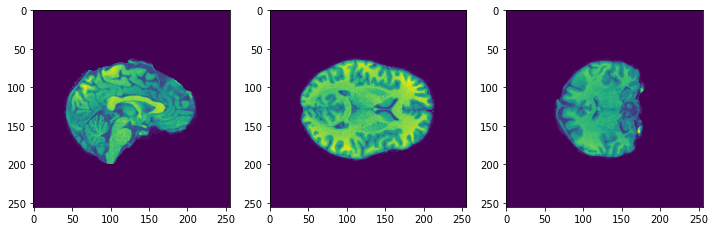

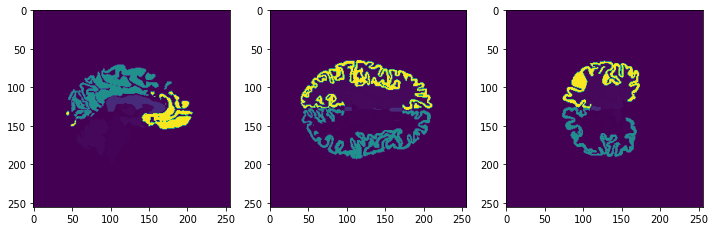

In [23]:
print("Dataset size: {}".format(len(data)))
img = data[0][MRI]
seg = data[0][LABEL]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img[DATA])
plot_central_cuts(seg[DATA])

## 2. Whole brain segmentation

Let's define the experiment for whole brain segmentation:

In [24]:
experiment.set_name("Whole image based, 1 subject in batch")

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
import random
import numpy as np

import sys
import os
from optparse import OptionParser

import torch.backends.cudnn as cudnn
from torch import optim
import time

import pandas as pd

In [26]:
!pip install --quiet --upgrade unet 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from unet import UNet

from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from torch.utils.data import DataLoader, Subset
import warnings
import multiprocessing

In [27]:
num_subjects = len(data)
training_split_ratio = 1/2
num_training_subjects = int(training_split_ratio * num_subjects)

# training_subjects = subjects[:num_training_subjects]
# validation_subjects = subjects[num_training_subjects:]

training_subjects = subjects[:20]
validation_subjects = subjects[20:40] # experimenting just on 20 first subjects

training_set = torchio.SubjectsDataset(
    training_subjects, transform=None)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=None)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 20 subjects
Validation set: 20 subjects


The data is really heavy, so lets try to start with 1 subject/ batch:

In [28]:
training_batch_size = 1
validation_batch_size = 1

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=multiprocessing.cpu_count(),
)

#### Defining the model and optimizer for training

At first check if we have GPU onborad:

In [29]:
 torch.cuda.is_available()

True

In [30]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [31]:
def get_iou_score(prediction, ground_truth):
    intersection, union = 0, 0
    intersection += np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
    union += np.logical_or(prediction > 0, ground_truth > 0).astype(np.float32).sum()
    iou_score = float(intersection) / union
    return iou_score

def calculate_metrics(surface, prediction):
    dsc = compute_dice_coefficient(surface, prediction)
    asd_mean, asd_std = compute_average_surface_distance(
        compute_surface_distances(
            surface, prediction, spacing_mm=(1,1,1))
    )
    
    iou = get_iou_score(prediction, surface)
    
    return dsc, asd_mean, asd_std, iou        
        
## see more in https://github.com/deepmind/surface-distance
def validate_dsc_asd(model, loader):
    
    dsc, asd_mean, asd_std, iou = [], [], [], []
    model.eval()

    for batch_idx, batch in enumerate(tqdm(loader)):
            inputs, targets = prepare_batch(batch, device)
            with torch.no_grad():
                logits = forward(model, inputs)
            labels = logits.argmax(dim=CHANNELS_DIMENSION)
            prediction = labels[0].cpu().numpy().astype(np.uint8)
            dsc_temp, asd_mean_temp, asd_std_temp, iou_temp = calculate_metrics(
                targets.cpu().numpy().astype(np.uint8)[0][0], 
                prediction
            )
            dsc.append(dsc_temp)
            asd_mean.append(asd_mean_temp)
            asd_std.append(asd_std_temp)
            iou.append(iou_temp)
    
    return dsc, asd_mean, asd_std, iou

def prepare_batch(batch, device):
    """
    The function loaging *nii.gz files, sending to the devise.
    For the LABEL in binarises the data.
    """
    inputs = batch[MRI][DATA].to(device)
    targets = batch[LABEL][DATA]
    targets[0][0][(np.isin(targets[0][0], LIST_ASEG))] = 1
    targets[targets >= 1000] = 1
    targets[targets != 1] = 0
    targets = targets.to(device)    
    return inputs, targets

def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler=False, experiment= False):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs.float())
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            
            if is_training:
                batch_loss.backward()
                optimizer.step()
                
            # appending the loss
            epoch_losses.append(batch_loss.item())
           
            if experiment:
                if action == Action.TRAIN:
                    experiment.log_metric("train_dice_loss", batch_loss.item())
                elif action == Action.VALIDATE:
                    experiment.log_metric("validate_dice_loss", batch_loss.item())
                    
            del inputs, targets, logits, probabilities, batch_losses
    
    epoch_losses = np.array(epoch_losses)
#     print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    
    return epoch_losses 

def train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler,
          weights_stem, save_epoch= 1, experiment= False, verbose = True):
    
    start_time = time.time()
    epoch_train_loss, epoch_val_loss = [], []
    
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer, scheduler, experiment)
    
    for epoch_idx in range(1, num_epochs + 1):
        
        epoch_train_losses = run_epoch(epoch_idx, Action.TRAIN, training_loader, 
                                       model, optimizer, scheduler, experiment)
        epoch_val_losses = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, 
                                     model, optimizer, scheduler, experiment)
        
        # 4. Print metrics
        if verbose:
            clear_output(True)
            print("Epoch {} of {} took {:.3f}s".format(epoch_idx, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(epoch_train_losses[-1]))
            print("  validation loss: \t\t\t{:.6f}".format(epoch_val_losses[-1]))    
        
        epoch_train_loss.append(np.mean(epoch_train_losses))
        epoch_val_loss.append(np.mean(epoch_val_losses))
        
        # 5. Plot metrics
        if verbose:
            plt.figure(figsize=(10, 5))
            plt.plot(epoch_train_loss, label='train')
            plt.plot(epoch_val_loss, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
        
        if scheduler:     
            scheduler.step(np.mean(epoch_val_losses))
        # comet ml
        if experiment:
            experiment.log_epoch_end(epoch_idx)
        #saving the model
        # if (epoch_idx% save_epoch == 0):
        #     torch.save(model.state_dict(), f'weights/{weights_stem}_epoch_{epoch_idx}.pth')

In [32]:
def get_model_and_optimizer(device, num_encoding_blocks=3, out_channels_first_layer=4, patience=3):
  # Better to train with num_encoding_blocks=3, out_channels_first_layer = 16 '''
  
  # repoducibility
  torch.manual_seed(0)
  np.random.seed(0)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
    
  model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=num_encoding_blocks,
        out_channels_first_layer=out_channels_first_layer,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    
  optimizer = torch.optim.AdamW(model.parameters())
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
  return model, optimizer, scheduler

model, optimizer, scheduler = get_model_and_optimizer(device)

Epoch 2 of 5 took 244.879s
  training loss (in-iteration): 	0.880622
  validation loss: 			0.917655


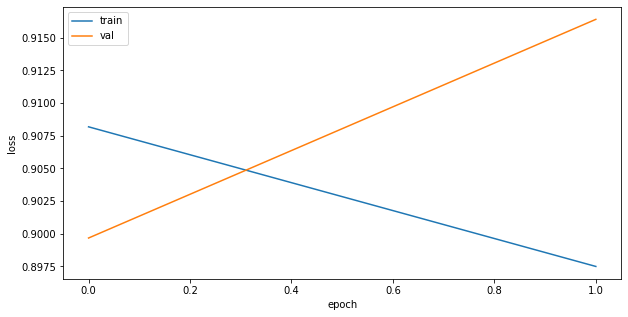

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchio/data/image.py:143: UserWarning: Not specifying the image type is deprecated and will be mandatory in the future. You can probably use tio.ScalarImage or tio.LabelMap instead
  'Not specifying the image type is deprecated and will be'
/usr/local/lib/python3.7/dist-packages/torchio/data/image.py:143: UserWarning: Not specifying the image type is deprecated and will be mandatory in the future. You can probably use tio.ScalarImage or tio.LabelMap instead
  'Not specifying the image type is deprecated and will be'
  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchio/data/image.py:143: UserWarning: Not specifying the image type is deprecated and will be mandatory in the future. You can probably use tio.ScalarImage or tio.LabelMap instead
  'Not specifying the image type is deprecated and will be'
/usr/local/lib/python3.7/dist-packages/torchio/data/image.py:143: UserWarning: No

In [ ]:
# executes ~ 25 minutes
torch.cuda.empty_cache()

num_epochs = 5
weights_stem = 'whole_images'
train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler = False,  weights_stem = weights_stem )

We expect to get `DICE > 0.9` on validation after 40 epochs on the whole sample.

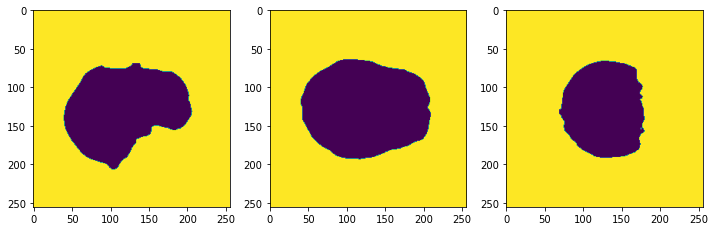

In [ ]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs.float())
labels = logits.argmax(dim=CHANNELS_DIMENSION)
foreground = labels[0].cpu().numpy().astype(np.uint8)
plot_central_cuts(foreground)

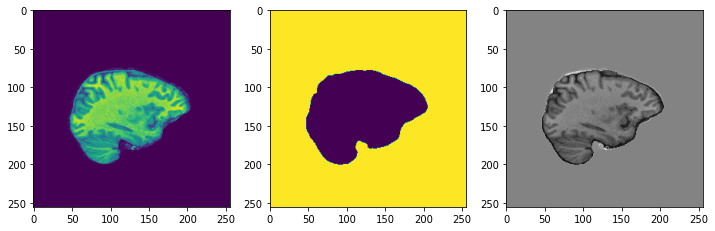

In [ ]:
plot_predicted(inputs, foreground, 30, title="")

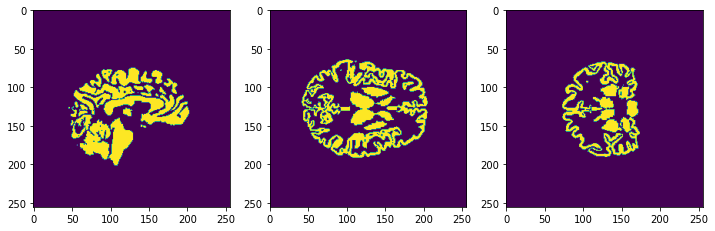

In [ ]:
plot_central_cuts(targets[0].cpu())

In [ ]:
print(labels[0].size(), targets[0][0].size())
get_dice_score(labels[0],targets)

torch.Size([256, 256, 256]) torch.Size([256, 256, 256])


tensor([[1.6237e-06]], device='cuda:0')

## 3. Patch-based segmentation

Let's fedine another experiment within the same workspace in `COMET ML`:

In [ ]:
experiment.set_name("Patch based, 64 batch")

In [ ]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 16

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [ ]:
import SimpleITK as sitk

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        experiment.log_epoch_end(epoch_idx)
        
        
def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs.float())
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
            if action == Action.TRAIN:
                experiment.log_metric("train_dice_loss", batch_loss.item())
            elif action == Action.VALIDATE:
                experiment.log_metric("validate_dice_loss", batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)

num_epochs = 5

weights_stem = 'patches'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)

100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


Validation mean loss: 0.895
Starting epoch 1


100%|██████████| 10/10 [00:39<00:00,  3.96s/it]


Training mean loss: 0.867


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


Validation mean loss: 0.890
Starting epoch 2


100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


Training mean loss: 0.881


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


Validation mean loss: 0.886
Starting epoch 3


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


Training mean loss: 0.886


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


Validation mean loss: 0.849
Starting epoch 4


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Training mean loss: 0.871


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


Validation mean loss: 0.890
Starting epoch 5


100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


Training mean loss: 0.882


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]

Validation mean loss: 0.864


/usr/local/lib/python3.7/dist-packages/torchio/data/inference/aggregator.py:162: RuntimeWarning:

Medical image frameworks such as ITK do not support int64. Casting to int32...



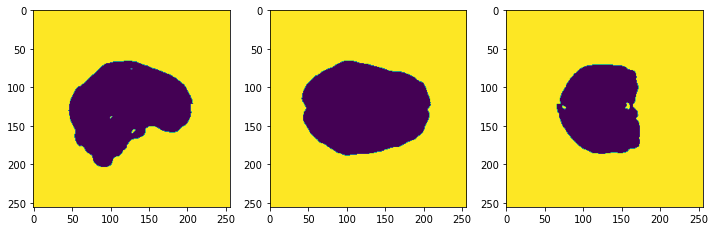

In [ ]:
import nibabel as nib
sample = random.choice(validation_set)
input_tensor = sample[MRI][DATA][0]
patch_size = 64, 64, 64  # we can user larger or smaller patches for inference
patch_overlap = 4, 4, 4
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch[MRI][DATA].to(device).float()
        locations = patches_batch['location']
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)
plot_central_cuts(aggregator.get_output_tensor())

In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)
num_epochs = 40
weights_stem = 'patches'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)

100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


Validation mean loss: 0.882
Starting epoch 1


100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


Training mean loss: 0.867


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Validation mean loss: 0.889
Starting epoch 2


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


Training mean loss: 0.879


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


Validation mean loss: 0.878
Starting epoch 3


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


Training mean loss: 0.886


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


Validation mean loss: 0.846
Starting epoch 4


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Training mean loss: 0.872


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Validation mean loss: 0.890
Starting epoch 5


100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


Training mean loss: 0.886


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


Validation mean loss: 0.869
Starting epoch 6


100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Training mean loss: 0.884


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


Validation mean loss: 0.874
Starting epoch 7


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Training mean loss: 0.881


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Validation mean loss: 0.868
Starting epoch 8


100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


Training mean loss: 0.867


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


Validation mean loss: 0.860
Starting epoch 9


100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


Training mean loss: 0.864


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Validation mean loss: 0.869
Starting epoch 10


100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Training mean loss: 0.862


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Validation mean loss: 0.857
Starting epoch 11


100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


Training mean loss: 0.860


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


Validation mean loss: 0.845
Starting epoch 12


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Training mean loss: 0.849


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Validation mean loss: 0.844
Starting epoch 13


100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Training mean loss: 0.835


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


Validation mean loss: 0.861
Starting epoch 14


100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


Training mean loss: 0.839


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


Validation mean loss: 0.844
Starting epoch 15


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Training mean loss: 0.834


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Validation mean loss: 0.832
Starting epoch 16


100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Training mean loss: 0.839


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Validation mean loss: 0.798
Starting epoch 17


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


Training mean loss: 0.823


100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


Validation mean loss: 0.822
Starting epoch 18


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


Training mean loss: 0.807


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


Validation mean loss: 0.792
Starting epoch 19


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


Training mean loss: 0.791


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


Validation mean loss: 0.800
Starting epoch 20


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Training mean loss: 0.795


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Validation mean loss: 0.793
Starting epoch 21


100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


Training mean loss: 0.794


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


Validation mean loss: 0.811
Starting epoch 22


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Training mean loss: 0.803


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


Validation mean loss: 0.793
Starting epoch 23


100%|██████████| 10/10 [00:46<00:00,  4.65s/it]


Training mean loss: 0.788


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


Validation mean loss: 0.789
Starting epoch 24


100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


Training mean loss: 0.787


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


Validation mean loss: 0.791
Starting epoch 25


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Training mean loss: 0.770


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Validation mean loss: 0.826
Starting epoch 26


100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


Training mean loss: 0.764


100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


Validation mean loss: 0.792
Starting epoch 27


100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


Training mean loss: 0.768


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


Validation mean loss: 0.757
Starting epoch 28


100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


Training mean loss: 0.751


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Validation mean loss: 0.763
Starting epoch 29


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Training mean loss: 0.747


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


Validation mean loss: 0.751
Starting epoch 30


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


Training mean loss: 0.751


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Validation mean loss: 0.772
Starting epoch 31


100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Training mean loss: 0.719


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Validation mean loss: 0.754
Starting epoch 32


100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Training mean loss: 0.720


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


Validation mean loss: 0.720
Starting epoch 33


100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


Training mean loss: 0.739


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Validation mean loss: 0.753
Starting epoch 34


100%|██████████| 10/10 [00:46<00:00,  4.65s/it]


Training mean loss: 0.715


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Validation mean loss: 0.775
Starting epoch 35


100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Training mean loss: 0.763


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Validation mean loss: 0.735
Starting epoch 36


100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Training mean loss: 0.710


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


Validation mean loss: 0.761
Starting epoch 37


100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


Training mean loss: 0.692


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


Validation mean loss: 0.758
Starting epoch 38


100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Training mean loss: 0.717


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


Validation mean loss: 0.714
Starting epoch 39


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Training mean loss: 0.708


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


Validation mean loss: 0.771
Starting epoch 40


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Training mean loss: 0.690


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]

Validation mean loss: 0.744


We expect to see loss < 0.7 after 40 epochs.

/usr/local/lib/python3.7/dist-packages/torchio/data/inference/aggregator.py:162: RuntimeWarning:

Medical image frameworks such as ITK do not support int64. Casting to int32...



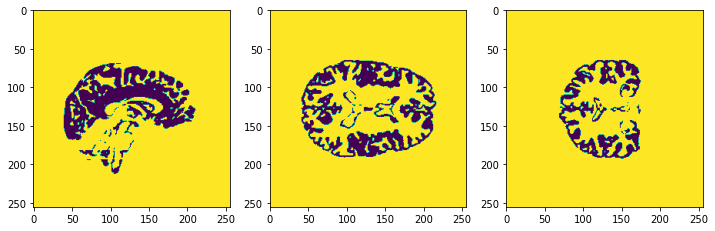

In [ ]:
sample = random.choice(validation_set)
input_tensor = sample[MRI][DATA][0]
patch_size = 64, 64, 64  # we can user larger or smaller patches for inference
patch_overlap = 4, 4, 4
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch[MRI][DATA].to(device).float()
        locations = patches_batch['location']
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)
plot_central_cuts(aggregator.get_output_tensor())

## 4. What else?

1. Crop unnesessary parts of all images, be sure you are using only relevant for segmentation brain parts. Avoid empty corners.
2. Batch size and patch size - the bigger the better, and patch size of 128x128x128 is the best strategy (yet watch your time and memory, it is limited).
3. U-net: is it deep enough or wide enough? Watch your memory :)
3. Augmentations for patch based segmentation it is a must. Be sure, you have enough time to train model, augmentation with rotation, smothing with double training time
4. Advanced loss: CrossEntropy + DICE are your best friends.
5. Do not you forget about adjusting learning rate with training.


**Dont waste your time:**
1. Adding patch localization to a model input.
2. Focal loss.
3. Training on non-zero patches.